In [1]:
import numpy as np
import pandas as pd
import torch
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, Batch
from torch_geometric.transforms import LocalDegreeProfile
import torch.nn.functional as F
from torch_geometric.datasets import GemsecDeezer
from sklearn.metrics import accuracy_score, roc_auc_score
import pathlib
import utils
import matplotlib.pyplot as plt

In [2]:
base_dir = pathlib.Path().resolve()
df = pd.read_csv(f'{base_dir}/datasets/fingerSimilarity.csv')

In [5]:
table = utils.get_top_cells(df, 0.8)
print(table.shape)
se_df = pd.read_csv(f'{base_dir}/datasets/sideEffectsfillterd.csv')
drug_dccs = list(se_df['DCC_ID'].to_numpy())
se_df

(212, 3)


,Unnamed: 0,abdominal abscess,abdominal discomfort,abdominal distension,abdominal pain,abdominal pain lower,abdominal pain upper,abdominal tenderness,abnormal behaviour,abnormal dreams,...,white blood cell count decreased,white blood cell count increased,white blood cell disorder,wound,wound complication,wound haemorrhage,wound infection,yawning,yellow skin,DCC_ID
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC0162
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC1338
2,2,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC1395
3,3,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,DCC0306
4,4,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC1097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303,303,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC0222
304,304,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC1637
305,305,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC1740
306,306,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,DCC0147


In [21]:
# loading all edges and scores
all_edges = []
all_edges_scores = []
nodes_list = list()
nodes_dict = dict()
reverse_node_data_dict = dict()
count = 0
for row in table:
    score = row[2]
    d1 = row[0]
    d2 = row[1]
    edge = [row[0], row[1]]
    reverse_edge = [row[1], row[0]]
    if edge not in all_edges and reverse_edge not in all_edges:
        # adding edges with DCC code
        all_edges.append(edge)
        all_edges.append(reverse_edge)
        # adding edges scores
        all_edges_scores.append(float(score))
        all_edges_scores.append(float(score))
    if d1 not in nodes_list:
        nodes_list.append(d1)
        nodes_dict[d1] = count
        reverse_node_data_dict[count] = d1
        count += 1
    if d2 not in nodes_list:
        nodes_list.append(d2)
        nodes_dict[d2] = count
        reverse_node_data_dict[count] = d2
        count += 1

all_edges_coded = []
for row in table:
    d1 = nodes_dict[row[0]]
    d2 = nodes_dict[row[1]]
    edge = [d1, d2]
    reverse_edge = [d2, d1]
    if edge not in all_edges_coded and reverse_edge not in all_edges_coded:
        all_edges_coded.append(edge)
        all_edges_coded.append(reverse_edge)

nodes_data = []

for row in se_df.iloc[:, :se_df.shape[1]].values:
    drug = np.squeeze(row[se_df.shape[1]-1:])
    if drug in list(nodes_dict.keys()):
        nodes_data.append(list(row[1:se_df.shape[1]-1]))
nodes_data = np.array(nodes_data)

In [33]:
nodes_data.shape

(109, 1090)

In [35]:
cols = []

for i in range(nodes_data.shape[1]):
    col = nodes_data[:, i]
    if 1 in col:
        cols.append(col)
cols = np.array(cols)
nodes_data = cols.T
nodes_data.shape

(109, 708)

In [36]:
nodes_data = torch.from_numpy(np.array(nodes_data))
edges_data = torch.from_numpy(np.array(all_edges_coded))
edges_attr = torch.from_numpy(np.array(all_edges_scores))

# data = Data(x=nodes_data, edge_index=edges_data.T, edge_attr=edges_attr)
data = Data(y=nodes_data, edge_index=edges_data.T, edge_attr=edges_attr)
# Automatically creating 5 node features
ldp = LocalDegreeProfile()
data = ldp(data)
data

/home/sina/anaconda3/envs/pyg/lib/python3.8/site-packages/torch_geometric/data/storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'y', 'edge_attr'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


Data(edge_index=[2, 212], edge_attr=[212], y=[109, 708], x=[109, 5])

In [37]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hid_channels, out_channels):
        super(GNN, self).__init__()
        torch.manual_seed(0)
        self.conv1 = GCNConv(in_channels=in_channels, out_channels=hid_channels)
        self.conv2 = GCNConv(in_channels=hid_channels, out_channels=hid_channels)
        self.conv3 = GCNConv(in_channels=hid_channels, out_channels=out_channels)
        # self.lin1 = torch.nn.Linear(in_features=hid_channels, out_features=out_channels)

    def forward(self, x, edge_index, index=0):
        # print(x)
        x = self.conv1(x, edge_index)
        # print(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        # x = self.lin1(x)
        # x = x.sigmoid()
        return x

GNN(
  (conv1): GCNConv(5, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 708)
)
0.48434447253200996
Loss: 0.701, AUC Score: 0.48434447253200996
0.5054586842750358
0.49293971568083034
0.49297859311058734
0.5145357911696705
0.5156727418186052
0.5090542820610818
0.5087424405462447
0.5013210532998827
0.4965934158093677
0.47937181821015207
Loss: 0.217, AUC Score: 0.47937181821015207
0.4913955040590934
0.492658470914775
0.5006770132391808
0.49891079318561915
0.500529231943196
0.4998965277459873
0.496796115172789
0.48789590933997806
0.5148421577844453
0.5052127482305194
Loss: 0.177, AUC Score: 0.5052127482305194
0.5033800666559887
0.48585711941199766
0.5062242285954934
0.4964824207765672
0.494707938386478
0.5104635383412562
0.4955942551575997
0.5023456413161534
0.5177227614767977
0.5021782102258123
Loss: 0.162, AUC Score: 0.5021782102258123
0.5277403252326681
0.4954041847936936
0.48530698553954243
0.4975467099284738
0.5323022723759789
0.5133706118259403
0.5206177464512319
0.512141

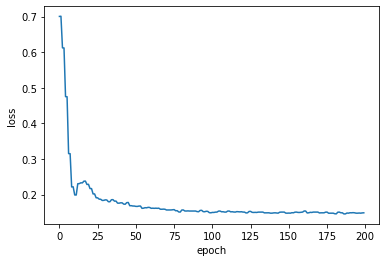

In [38]:
in_channels = data.num_features
hid_channels = 128
out_channels = data.y.shape[1]

model = GNN(in_channels=in_channels, hid_channels=hid_channels, out_channels=out_channels)
print(model)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def device_finder():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

auc_score = -1
losses = []
auc_score_list = []
for epoch in range(100):
    output = model(data.x, data.edge_index)
    loss = criterion(output, data.y.float())
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    temp_outputs = output.clone().detach().numpy()
    temp_labels = np.array(data.y)
    # print(temp_outputs.max(axis=1))
    try:
        auc_score = roc_auc_score(temp_labels, temp_outputs, average='weighted')
        print(auc_score)
    except Exception as e:
        print(e)
        pass
    loss = float("{:.3f}".format(loss.item()))
    losses.append(loss)
    auc_score_list.append(auc_score)
    # auc_score = float("{:.3f}".format(auc_score))
    if epoch % 10 == 0:
        print(f'Loss: {loss}, AUC Score: {auc_score}')

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

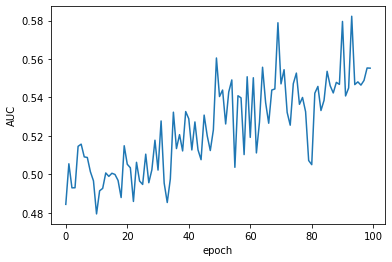

In [40]:
plt.plot(auc_score_list)
plt.xlabel('epoch')
plt.ylabel('AUC')
plt.show()